In [2]:
!pip install tensorflow
!pip install keras
!pip install scikeras
!pip install xgboost


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import xgboost as xgb

2024-12-09 08:25:29.112061: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 08:25:29.316765: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 08:25:29.507672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733732729.798617    8741 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733732729.908724    8741 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 08:25:30.551643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
data = pd.read_csv('./cleaned_data_2.csv')

In [5]:
X = data.drop('readmitted', axis=1)
y = data['readmitted']

#TRUE/FALSE becomes 1/0
X = X.replace({'TRUE': 1, 'FALSE': 0})

In [6]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Apply Label Encoding to categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [7]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# SMOTE to handle imbalanced samples
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

In [17]:
# Design the autoencoder
input_dimension = X_train_resampled.shape[1]
encoding_dimension = input_dimension // 2  

# Autoencoder architecture
input_layer = Input(shape=(input_dimension,))

encoder = Dense(encoding_dimension * 2, activation='relu')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.3)(encoder)
encoder = Dense(encoding_dimension, activation='relu')(encoder)

decoder = Dense(input_dimension, activation='relu')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.3)(decoder)
decoder = Dense(encoding_dimension * 2, activation='relu')(decoder)
decoder = Dense(input_dimension, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Training autoencoder with early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(
    X_train_resampled, X_train_resampled,
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop],
    validation_data=(X_test, X_test)
)

# encoded features are extracted
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_resampled)
X_test_encoded = encoder_model.predict(X_test)

Epoch 1/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 956.1739 - val_loss: 12.7055
Epoch 2/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 117.1911 - val_loss: 14.7321
Epoch 3/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 104.8901 - val_loss: 33.8787
Epoch 4/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 97.5206 - val_loss: 14.8829
Epoch 5/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 89.4821 - val_loss: 8.2333
Epoch 6/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 84.5393 - val_loss: 5.7422
Epoch 7/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 79.1747 - val_loss: 8.1846
Epoch 8/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 74.2430 - val_loss: 9.6612
Epoch 9/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 70.4133 - val_loss: 8.0340
Epoch 10/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 66.3560 - val_loss: 7.4787
Epoch 11/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 63.6348 - val_loss: 8.2170
Epoch

In [ ]:
#Large and Thought Out Grid Search
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 8, 10],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

#Results that we got
param_grid = {
    'n_estimators': [300],
    'max_depth': [10],
    'learning_rate': [0.3],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
}

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss'
)

In [21]:
warnings.filterwarnings("ignore", message=".*Parameters.*")

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_encoded, y_train_resampled)

# Best model
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters from Grid Search:")
print(best_params)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


Best Parameters from Grid Search:
{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}


In [22]:
y_pred = best_xgb.predict(X_test_encoded)
y_pred_proba = best_xgb.predict_proba(X_test_encoded)[:, 1]

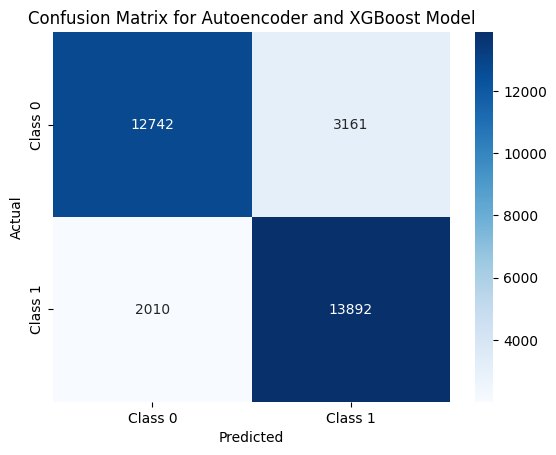

Accuracy: 0.84
Precision: 0.81
Recall: 0.87
F1-Score: 0.84
AUC-ROC: 0.91


In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f"Confusion Matrix for Autoencoder and XGBoost Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

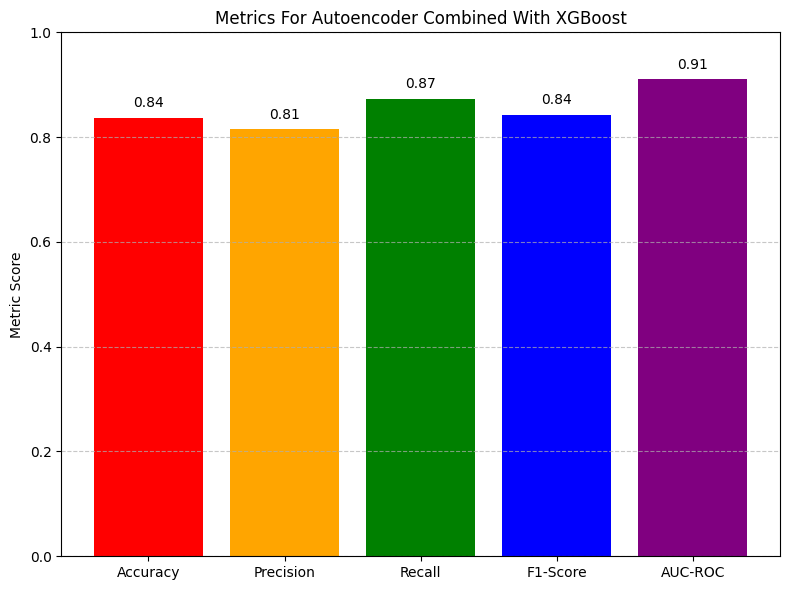

In [29]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['red', 'orange', 'green', 'blue', 'purple'])

plt.ylabel('Metric Score')
plt.title('Metrics For Autoencoder Combined With XGBoost')
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [32]:
!pip install shap --upgrade
!pip install lime


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 50.0 MB/s eta 0:00:00:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4a6cf352827f679b4f49d43b70476a585f5c1fe43cc0a343fae318194cb16823
  Stored in directory: /home/codespace/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


100%|===================| 31786/31805 [13:04<00:00]        

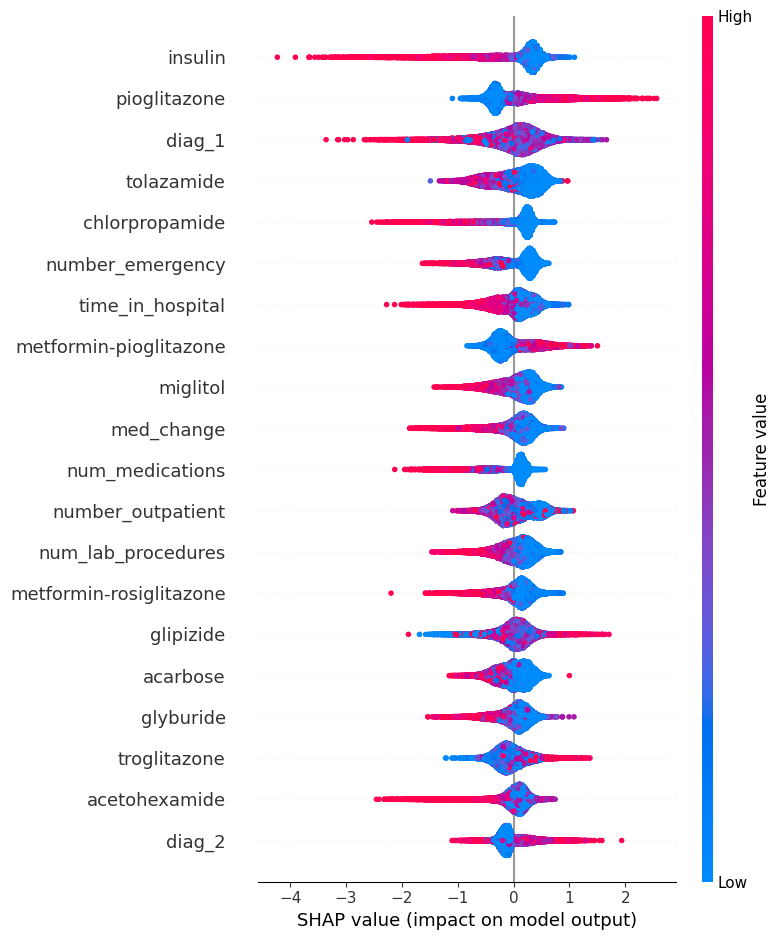

In [33]:
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = shap.Explainer(best_xgb, X_train_encoded)
shap_values = explainer(X_test_encoded)
shap.summary_plot(shap_values, X_test_encoded, feature_names=X.columns)

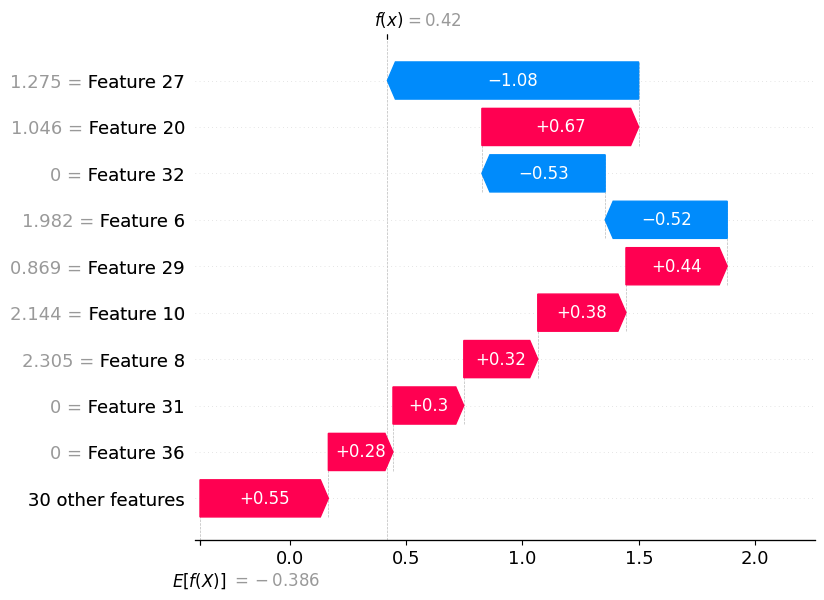

In [34]:
single_index = 0 
shap.waterfall_plot(shap_values[single_index])

lime_explainer = LimeTabularExplainer(
    training_data=X_train_encoded,
    feature_names=X.columns.tolist(), 
    class_names=["Not Readmitted", "Readmitted"],
    mode='classification'
)

instance_to_explain = X_test_encoded[single_index] 

lime_exp = lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=best_xgb.predict_proba
)

lime_exp.show_in_notebook()